In [1]:
suppressPackageStartupMessages(
    {suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(tidyr)
        library(ggplot2)        
        library(scales)
        library(patchwork) 
        library(purrr)
        library(dplyr)
    })
})

In [2]:
# Size and general style set up
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

# Load Data
player_data <- read_csv("https://raw.githubusercontent.com/FabianoGLentini/player-subscription-ml/refs/heads/main/data/players.csv")


# Data Science Project: Project Final Report


## Introduction:

## Methods & Results:

### Set up and intro to data: "TODO should rename later." 

In [3]:
# Wrangle data
#TODO will need additional wranggling due to poor or few varied sample categories
player_df <- player_data |> # TODO must consider reworking a joining of some labels in gender etc due to low representaions
            select( subscribe, gender, played_hours, experience, Age) |>
            drop_na() |>
            mutate(
                subscribe = as_factor(subscribe),  # lgl -> fct for analysis and modeling
                gender = as_factor(gender),        # chr -> fct for analysis and modeling
                played = factor(as.logical(played_hours)), # TODO may not use 
                experience = as_factor(experience) # chr -> fct for analysis and modeling
            ) 
 # Removed row with NA values, as it may distort the model      

# TODO FABIO check if player_hours should adjust to use a binary outcome, 
# either played or didn't play at all, or if any of the predictor should be removed.


### Training and Analysis:

In [4]:
# head(player_df) # TODO DELETE tmp  for set up 

In [5]:
set.seed(2025) # Don't change
# Prep for modelling
ply_df <- select(player_df, Age, subscribe, gender, played_hours)  # Exclude row_id & experience for modeling purposes

# Split step
player_split <- initial_split(ply_df, prop = 0.70, strata = subscribe) 
player_train <- training(player_split)
player_test <- testing(player_split)

# TODO FABIO CHECK boostraps() and if it would benefit our model with our small set

In [6]:
#TODO FABIO write up split/scale/recipe step reasoning
# 'initial split' Use Strata sub to balance the outcome for the bool prediction to avoid 
# imbalance in our test and train data split

# ... why use 75 25 split instead of 70/30 etc?

# ~ maybe explain why start with all predictors

In [7]:
#TODO FABIO ... search refractor options to reduce code clutter

# Recipes:
# Scale/Recipe

# Note: A = Age, G = gender and H = played_hours
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())
# # Recipe 02:
# Age + played_hours
rc_AH <- recipe(subscribe ~ Age + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 03:
# Age + gender 
rc_AG <- recipe(subscribe ~ Age + gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 04:
# gender + played_hours
rc_GH <- recipe(subscribe ~ gender + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 05:
# Age
rc_A <- recipe(subscribe ~ Age, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 06:
# gender
rc_G <- recipe(subscribe ~ gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 07:
# played_hours
rc_H <- recipe(subscribe ~ played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())



In [8]:
#TODO FABIO breackdown hypothesis for each recipe variation ...?

In [9]:
# Spec set up
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#TODO FABIO ... search refractor options to reduce code clutter
# Check mean and standard error through collect_metrics


In [10]:
# TODO FABIO ~ write up spec use and impl of vfold..?

In [11]:
# TODO FABIO confirm that not having set.seed here is fine as long as set.seed above code cell goes first
# K-fold cross-validation
set.seed(1234) # Don't change
kfolds <- vfold_cv(player_train, v = 5, strata = subscribe)
k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))


In [12]:
#TODO FABIO write reasonin + graph to show fold outcome
#Note the reason of using 10 10-fold is due to the small size data,
#hence it will improve the estimate and 

In [13]:
# Simplifying multi-model testing: https://www.youtube.com/watch?v=YZqbOATpjM4&t=139s
# Workflow Step
workflow_set <- workflow_set(
    preproc = list(
        AGH = rc_AGH,
        AH = rc_AH,
        AG = rc_AG,
        GH = rc_GH,
        A = rc_A,
        G = rc_G,
        H = rc_H
    ),
    models = list(knn_tune),
    cross = TRUE
)

# Tune workflow
# set.seed(22)

knn_tuned_set <- workflow_map(
    workflow_set,
    "tune_grid",
    resamples = kfolds,
    grid = k_vals,
    seed = 22
)


In [14]:
#TODO FABIO write workflow step use case/what it functionally is doing 

In [15]:

options(repr.plot.width = 15, repr.plot.height = 5)
# Get metrics all in one
all_metrics_collected <- workflow_map(
    knn_tuned_set,
    metrics = metric_set(accuracy, recall, precision)
) 

all_metrics_collected_res <- collect_metrics(all_metrics_collected)

→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 7 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x2





In [16]:
# all_metrics_collected_res
#TODO TMP trying to regain neighbours
res_All_met_tuned <- all_metrics_collected |>
            rowwise() |>
            mutate(metrics = list(collect_metrics(result)),
                  wflow_id = fct_recode(wflow_id,
                      "Age, gender and played hours" = "AGH_nearest_neighbor",
                      "Gender and played hours" = "GH_nearest_neighbor",
                      "Gender" = "G_nearest_neighbor",
                      "Age and gender" = "AG_nearest_neighbor",
                      "Age and played hours" = "AH_nearest_neighbor",
                      "Age" = "A_nearest_neighbor",
                      "Played hours" = "H_nearest_neighbor",
                  )) |>
            unnest(metrics) |>
            select(wflow_id, .metric, mean, neighbors, std_err) |>
            arrange(desc(mean))
# ADD RANKING
ranked_met <- res_All_met_tuned |>
            mutate(rank = seq(1, nrow(res_All_met_tuned), 1))
# ranked_met
# Visualize result
options(repr.plot.width = 8, repr.plot.height = 5)

plot_met_tmp <- ggplot(ranked_met, aes(x = rank, y = mean, color = wflow_id)) +
                geom_point() +
                ylim(c(0,1)) + 
                labs(x = "Ranke by metric mean", y = "Metric mean percentage", color = "Predictor Combinations") 

# plot_met_tmp


Warning message:
“There were 7 warnings in `mutate()`.
The first warning was:
ℹ In argument: `wflow_id = fct_recode(...)`.
ℹ In row 1.
Caused by warning:
! Unknown levels in `f`: GH_nearest_neighbor, G_nearest_neighbor, AG_nearest_neighbor, AH_nearest_neighbor, A_nearest_neighbor, H_nearest_neighbor
ℹ Run `dplyr::last_dplyr_warnings()` to see the 6 remaining warnings.”


In [17]:
# METRIC set up
# Accuracy
acc_met <- res_All_met_tuned |>
            filter(.metric ==  "accuracy")
acc_met_rank <- mutate(acc_met, rank = seq(1, nrow(acc_met), 1))
acc_met_plot <- plot_met_tmp %+% acc_met_rank +
                ggtitle("Ranked by Accuracy Mean")



# Precision
prec_met <- res_All_met_tuned |>
            filter(.metric ==  "precision")
prec_met_rank <- mutate(prec_met, rank = seq(1, nrow(prec_met), 1))
prec_met_plot <- plot_met_tmp %+% prec_met_rank +
                ggtitle("Ranked by Precision Mean")



# Recall
rec_met <- res_All_met_tuned |>
            filter(.metric ==  "recall")
rec_met_rank <- mutate(rec_met, rank = seq(1, nrow(rec_met), 1))
rec_met_plot <- plot_met_tmp %+% rec_met_rank +
                ggtitle("Ranked by Recall Mean")



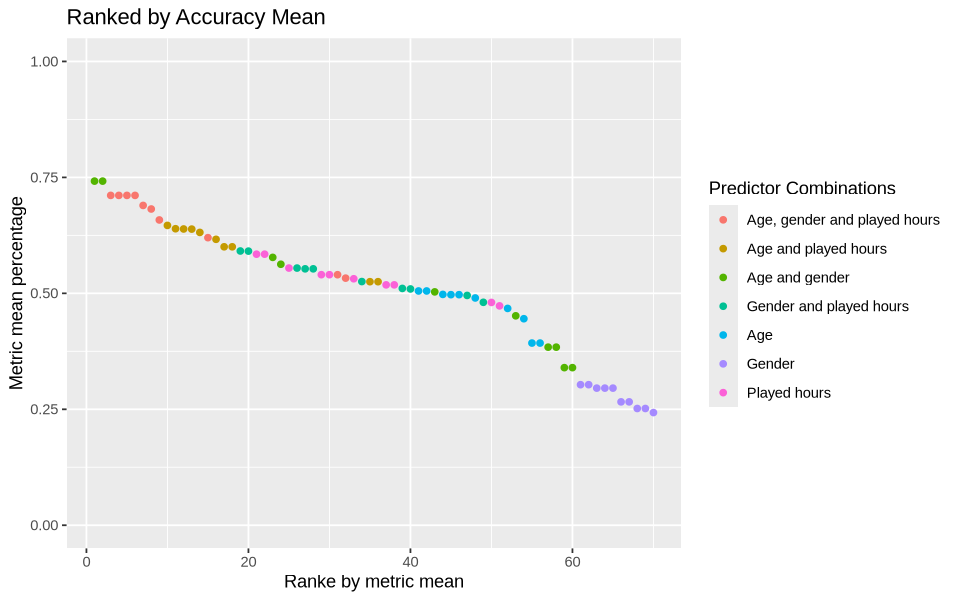

In [18]:
# Accuracy tuned metric plot
acc_met_plot

In [19]:
#TODO write about the result acc

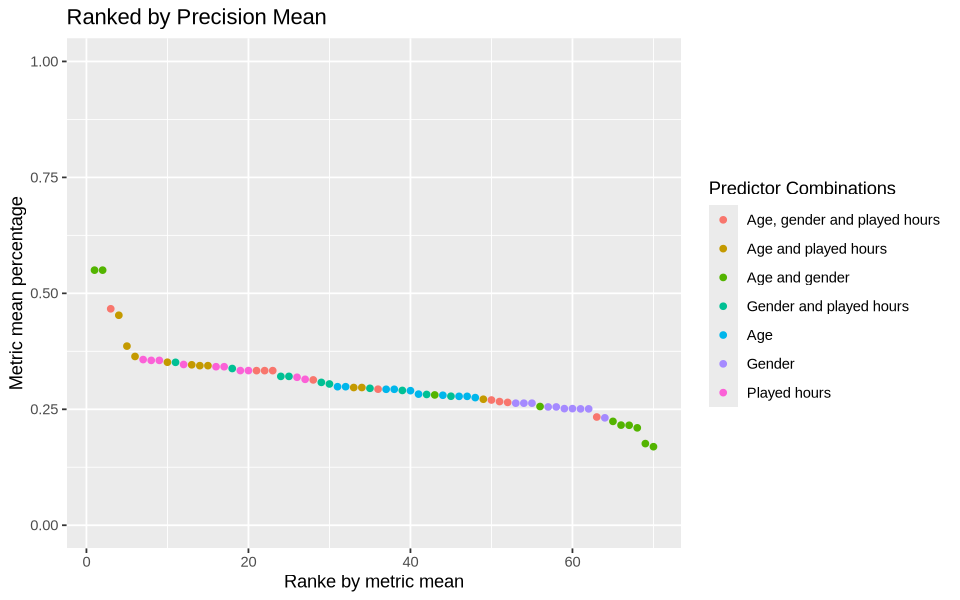

In [20]:
# Accuracy tuned metric prec
prec_met_plot

In [21]:
#TODO write about the result prec

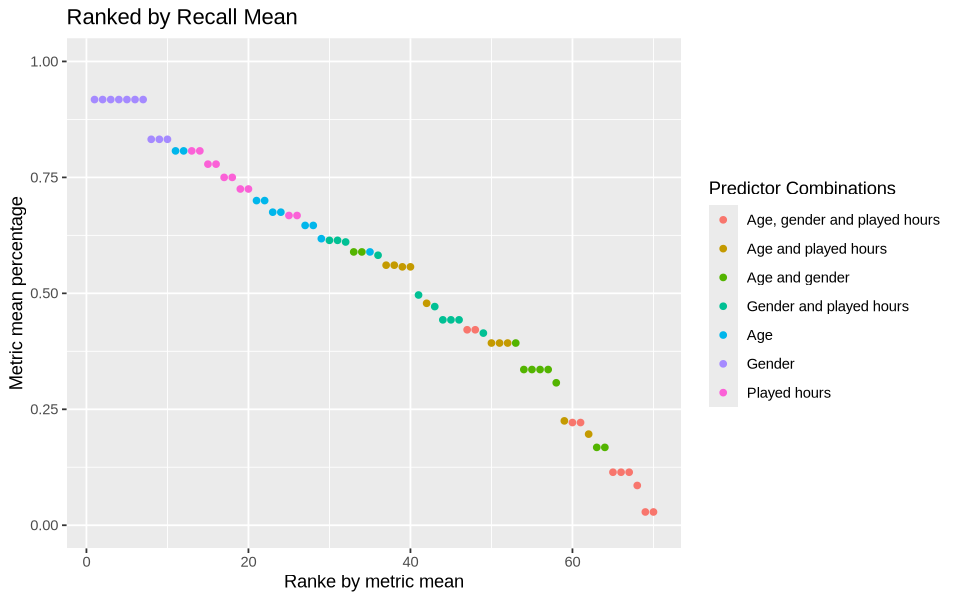

In [22]:
# Accuracy tuned metric rec
rec_met_plot

In [23]:
#TODO write about the result rec

$x
[1] "K neighbors"

$y
[1] "Accuracy percentage"

$colour
[1] "Predictor Combinations"

$title
[1] "K-nn performance of K by Accuracy"

attr(,"class")
[1] "labels"

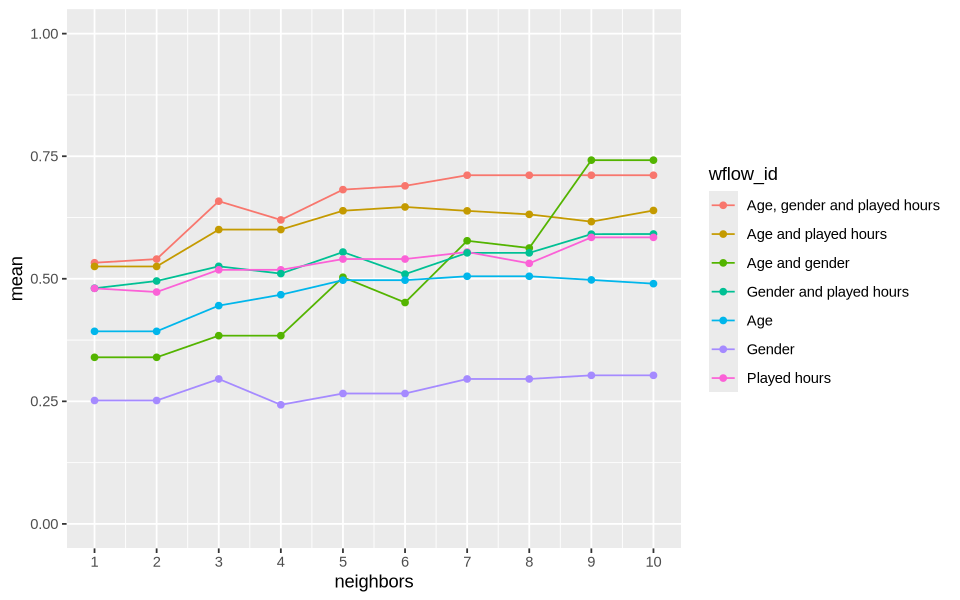

In [38]:
# LINE Graph showing k performance for each recipe
overlapped_line_acc <- ggplot(acc_met, aes(x = neighbors, y = mean, color = wflow_id)) +
                        geom_line()+
                        geom_point() + 
                        ylim(c(0, 1)) + 
                        scale_x_continuous(breaks = seq(0,10,1))
                        labs(
                            x = "K neighbors", 
                            y = "Accuracy percentage",  
                            color = "Predictor Combinations",
                            title = "K-nn performance of K by Accuracy")  
                        

overlapped_line_acc

In [25]:
# FIT MODEL:
# slice(ten_acc_rank_result, 1)
# head(ten_acc_rank_result)
# final_fit <- extract_workflow(all_metrics_collected, id = "AGH_nearest_neighbor")

# # library(vip)

# final_fit |>
#     extract_fit_parsnip() |>
#     vip(geom = "col")

### Player Type Exploration: "TODO may need renaming"

## Discussion:

### Reference 

##### Data Science programming techniques and approaches:
- **Clustering prediction:** https://www.youtube.com/watch?v=z57i2GVcdww
- **Simplifying multi-model set up + testing:** https://www.youtube.com/watch?v=YZqbOATpjM4
- **Tuning and comparing models using Workflowse:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models.html
- **Useful example of report/tutorial for tidy models:** https://optimumsportsperformance.com/blog/k-nearest-neighbor-tidymodels-tutorial/
- **Additional breakdown on workflow_set usage:** https://www.youtube.com/watch?v=R95lWUDtL5A
- **Workflow_set documentation on results:** https://workflowsets.tidymodels.org/reference/collect_metrics.workflow_set
- **Workflow_set tunning and comparing documentation:** https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models

In [33]:
#TODO tmp info grounds
?scale_x_continuous

scale_continuous {ggplot2},R Documentation
name,"The name of the scale. Used as the axis or legend title. If waiver(), the default, the name of the scale is taken from the first mapping used for that aesthetic. If NULL, the legend title will be omitted."
breaks,"One of: NULL for no breaks waiver() for the default breaks computed by the transformation object A numeric vector of positions A function that takes the limits as input and returns breaks as output (e.g., a function returned by scales::extended_breaks()). Note that for position scales, limits are provided after scale expansion. Also accepts rlang lambda function notation."
minor_breaks,"One of: NULL for no minor breaks waiver() for the default breaks (one minor break between each major break) A numeric vector of positions A function that given the limits returns a vector of minor breaks. Also accepts rlang lambda function notation. When the function has two arguments, it will be given the limits and major breaks."
n.breaks,An integer guiding the number of major breaks. The algorithm may choose a slightly different number to ensure nice break labels. Will only have an effect if breaks = waiver(). Use NULL to use the default number of breaks given by the transformation.
labels,One of: NULL for no labels waiver() for the default labels computed by the transformation object A character vector giving labels (must be same length as breaks) An expression vector (must be the same length as breaks). See ?plotmath for details. A function that takes the breaks as input and returns labels as output. Also accepts rlang lambda function notation.
limits,"One of: NULL to use the default scale range A numeric vector of length two providing limits of the scale. Use NA to refer to the existing minimum or maximum A function that accepts the existing (automatic) limits and returns new limits. Also accepts rlang lambda function notation. Note that setting limits on positional scales will remove data outside of the limits. If the purpose is to zoom, use the limit argument in the coordinate system (see coord_cartesian())."
expand,"For position scales, a vector of range expansion constants used to add some padding around the data to ensure that they are placed some distance away from the axes. Use the convenience function expansion() to generate the values for the expand argument. The defaults are to expand the scale by 5% on each side for continuous variables, and by 0.6 units on each side for discrete variables."
oob,One of: Function that handles limits outside of the scale limits (out of bounds). Also accepts rlang lambda function notation. The default (scales::censor()) replaces out of bounds values with NA. scales::squish() for squishing out of bounds values into range. scales::squish_infinite() for squishing infinite values into range.
na.value,Missing values will be replaced with this value.
transform,"For continuous scales, the name of a transformation object or the object itself. Built-in transformations include ""asn"", ""atanh"", ""boxcox"", ""date"", ""exp"", ""hms"", ""identity"", ""log"", ""log10"", ""log1p"", ""log2"", ""logit"", ""modulus"", ""probability"", ""probit"", ""pseudo_log"", ""reciprocal"", ""reverse"", ""sqrt"" and ""time"". A transformation object bundles together a transform, its inverse, and methods for generating breaks and labels. Transformation objects are defined in the scales package, and are called ⁠transform_<name>⁠. If transformations require arguments, you can call them from the scales package, e.g. scales::transform_boxcox(p = 2). You can create your own transformation with scales::new_transform()."
